In [1]:
import os
import sys
import time as t_util
import numpy as np
import cftime
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml


In [2]:
#Read main path
with open('../path_main.txt', 'r') as file:    path_main = file.read()

dir_data_HSIchg = f'{path_main}Data/Plot_preparation/HSI_changes/'
dir_data_ThrExc = f'{path_main}Data/Plot_preparation/Threshold_Exceedance/'
dir_data_HWMId  = f'{path_main}Data/Plot_preparation/HWMId/'
dir_scripts     = f'{path_main}Scripts/'
dir_names       = f'{path_main}Scripts/Model_lists/'
dir_fig         = f'{path_main}Figures/Paper_v2/'
if not os.path.exists(dir_fig): os.mkdir(dir_fig)
    

## Prepare variables and parameters

In [3]:
#Define cities
cities = ['Lisbon', 'Madrid', 'Barcelona', 'Rome', 'Athens', 'Istanbul', 'Sofia', 'Bucharest', 'Belgrade',
          'Zagreb', 'Milan', 'Budapest', 'Munich', 'Vienna', 'Prague', 'Paris', 'Brussels', 'Amsterdam',
          'London', 'Dublin', 'Hamburg', 'Copenhagen', 'Berlin', 'Warsaw', 'Kharkiv', 'Kyiv', 'Minsk','Vilnius', 
          'Riga', 'Moscow', 'NizhnyNovgorod', 'Kazan', 'SaintPetersburg', 'Helsinki', 'Stockholm', 'Oslo']

#Define output names
cities_out = ['Nizhny Novgorod' if city=='NizhnyNovgorod' else
              'Saint Petersburg' if city=='SaintPetersburg' else city for city in cities]

cities = np.array(cities)
    
HSI_out = {'TN': 'TN', 
           'TX': 'TX'}

# Load city coordinates
fname_coords = dir_scripts + 'City_coordinates.yml'
with open(fname_coords, 'r') as file:
    city_coords = yaml.safe_load(file)
    
#Define scenarios and variables
RCP = 'rcp85'

#Define models and RCPs which should be used
all_models = dict()
all_models = []
with open(dir_names + 'Models_CORDEX-EUR-11_RCP85.txt', 'r') as filehandle:
    for line in filehandle:
        all_models.append(eval(line[:-1]))

#Define warming levels
EMT_change = '3.0K'#'1.0K', '2.0K', 


## Plot preparation

In [11]:
#Labels
labels_leg = dict()
labels_leg['point']      = 'Central grid cell + IQR (models)'
labels_leg['difference'] = 'IQR (models)'

#Titles 1
tit_chg = dict()
tit_chg['JJA_mean'] = ' (JJA mean)'
tit_chg['Q90']      = ' (JJA, Q90)'
tit_chg['Ymax']     = 'x change'

#Titles 2
titles = dict()
titles['HSIchg'] = lambda HSI, THR_level : HSI +  tit_chg[t_method]
titles['ThrExc'] = lambda HSI, THR_level: 'Exceedance ' + HSI + '>' + THR_levels_vals[HSI + '_' + THR_level] + '°C'
titles['HWMID']  = lambda HSI, THR_level : 'HWMId-' + HSI


#Threshold levels
THR_levels = dict()
THR_levels['TN'] = 2 # 20 °C
THR_levels['TX'] = 3 # 30 °C

#Threshold levels
THR_levels_vals = dict()
THR_levels_vals['TN_Level2'] = '20'
THR_levels_vals['TX_Level3'] = '30'

#Limits
lims = dict()
lims['HWMID']  = [0, 40]
lims['ThrExc'] = [0, 130]
lims['HSIchg'] = [0, 5.5]

#Units
units = dict()
units['HSIchg'] = ' [°C]'
units['ThrExc'] = ' [d/y]'
units['HWMID']  = ''


## Plot

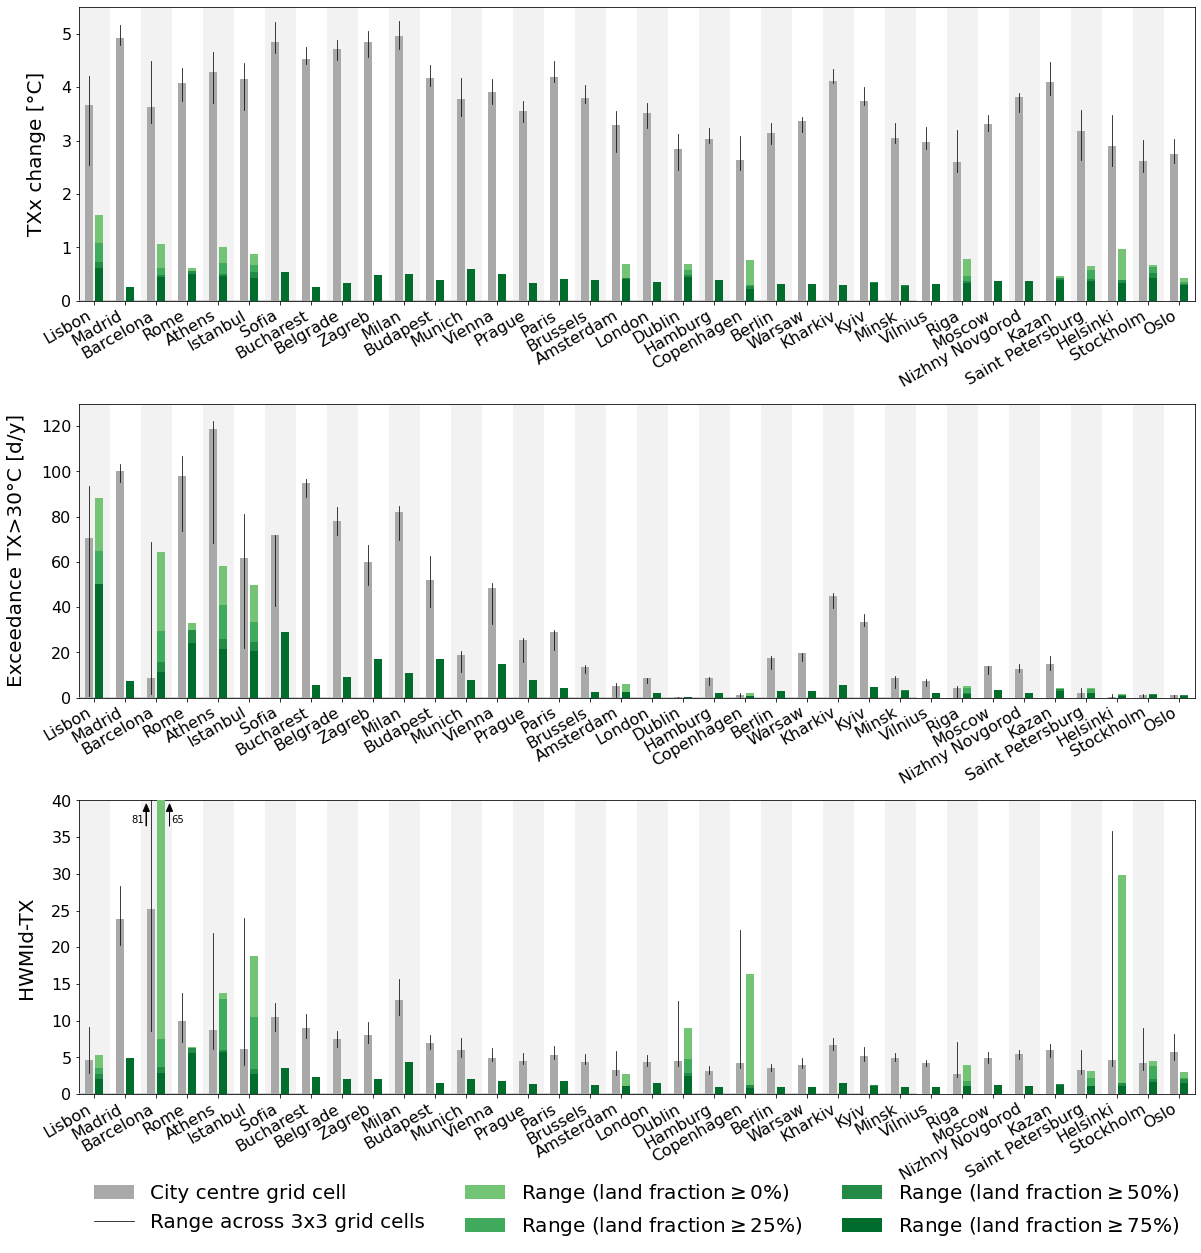

In [15]:
indicators = ['HSIchg', 'ThrExc', 'HWMID']
selections = ['values', 'difference']
N = len(selections)

#Define land fractions to select data
land_fracs   = [0, 25, 50, 75]
colors_fracs = ['#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15']
colors_fracs = ['#74c476', '#41ab5d', '#238b45', '#006d2c']

#Define HSI
HSI = 'TX'

#Select which time method to use for HSI changes ('JJA_mean', 'Q90', 'Ymax')
t_method = 'Ymax'

#Select threshold level
THR_level = 'Level' + str(THR_levels[HSI])
        
#Create figure
fig, axes = plt.subplots(3, 1, figsize=(20, 20))
plt.subplots_adjust(hspace=0.35)
p_all  = []
labels = []

#Loop over indicators
data_coll = dict()
for i1, indicator in enumerate(indicators):
    
    ax = axes[i1]
    
    
    if indicator=='HWMID':
        
        #Read data
        fname_pnt = dir_data_HWMId + 'EURO-CORDEX/HWMId-' + HSI + '_rcp85_EMT.nc'
        fname_3x3 = dir_data_HWMId + 'EURO-CORDEX_3x3/HWMId-' + HSI + '_rcp85_EMT.nc'
        data_HWMId_pnt = xr.open_dataset(fname_pnt)
        data_HWMId_3x3 = xr.open_dataset(fname_3x3)

        #Select EMT and quantile
        data_pnt     = data_HWMId_pnt.sel(EMT_change=EMT_change, quantile='Q50').HWMID
        data_3x3_min = data_HWMId_3x3.sel(range_3x3box='min', EMT_change=EMT_change, quantile='Q50').HWMID
        data_3x3_max = data_HWMId_3x3.sel(range_3x3box='max', EMT_change=EMT_change, quantile='Q50').HWMID
        data_rng     = data_3x3_max - data_3x3_min

    elif indicator=='ThrExc':
        
        #Read data
        fname_pnt = dir_data_ThrExc + 'EURO-CORDEX/HSIs-ThresholdExceedance_rcp85_EMT.nc'
        fname_3x3 = dir_data_ThrExc + 'EURO-CORDEX_3x3/HSIs-ThresholdExceedance_rcp85_EMT.nc'
        data_ThrExc_pnt = xr.open_dataset(fname_pnt)
        data_ThrExc_3x3 = xr.open_dataset(fname_3x3)

        #Select EMT, transformation and threshold level
        data_pnt     = data_ThrExc_pnt.sel(EMT_change=EMT_change, transformation='no_trans', THR_level=THR_level)[HSI]
        data_3x3_min = data_ThrExc_3x3.sel(range_3x3box='min', EMT_change=EMT_change, transformation='no_trans', THR_level=THR_level)[HSI]
        data_3x3_max = data_ThrExc_3x3.sel(range_3x3box='max', EMT_change=EMT_change, transformation='no_trans', THR_level=THR_level)[HSI]
        data_rng     = data_3x3_max - data_3x3_min
    
    elif indicator=='HSIchg':
    
        #Read data
        fname_pnt = dir_data_HSIchg + 'EURO-CORDEX/HSIs-changes_rcp85_EMT.nc'
        fname_3x3 = dir_data_HSIchg + 'EURO-CORDEX_3x3/HSIs-changes_rcp85_EMT.nc'
        data_HSIchg_pnt = xr.open_dataset(fname_pnt)
        data_HSIchg_3x3 = xr.open_dataset(fname_3x3)
        
        #Select EMT and averaging method
        data_pnt     = data_HSIchg_pnt.sel(EMT_change=EMT_change, t_method=t_method)[HSI]
        data_3x3_min = data_HSIchg_3x3.sel(range_3x3box='min', EMT_change=EMT_change, t_method=t_method)[HSI]
        data_3x3_max = data_HSIchg_3x3.sel(range_3x3box='max', EMT_change=EMT_change, t_method=t_method)[HSI]
        data_rng     = data_3x3_max - data_3x3_min

    #Save data for getting some numbers later
    data_coll[indicator] = (data_3x3_max - data_3x3_min).median('model').sel(land_frac=0)
        
    #Loop over cities
    for i3, city in enumerate(cities):

        #Loop over transformations
        for i2, selection in enumerate(selections):
            
            #Define x value
            x = (N+1)*i3 + i2
            
            if selection=='values':
                
                #Read data
                data_bar     = data_pnt.sel(city=city)
                data_bar_min = data_3x3_min.sel(city=city)
                data_bar_max = data_3x3_max.sel(city=city)
                
                #Select land fraction and calculate median
                Q50 = data_bar.median('model')
                Q25 = data_bar_min.sel(land_frac=0).median('model')#data_plot.quantile(0.25, 'model')
                Q75 = data_bar_max.sel(land_frac=0).median('model')#data_plot.quantile(0.75, 'model')

                #Plot median and range
                bp = ax.bar(x, Q50, color='darkgray', zorder=5)                
                lh = ax.plot([x, x],[Q25, Q75], color='k', linewidth=0.75, zorder=8)

                #Collect plot handles for legend
                if i3==0 and i1==0:
                    p_all.append(bp)
                    p_all.append(lh[0])
                    labels.append('City centre grid cell')                
                    labels.append('Range across 3x3 grid cells')                
                
            elif selection=='difference':

                #Loop over different minimum land fractions
                for color, land_frac in zip(colors_fracs, land_fracs):
                    
                    #Select data
                    Q50 = data_rng.sel(city=city, land_frac=land_frac).median('model')
                    
                    #Plot
                    bp = ax.bar(x, Q50, color=color, zorder=5)

                    #Collect plot handles for legend
                    if i3==0 and i1==0:
                        p_all.append(bp)         
                        labels.append('Range (land fraction$\geq$' + str(land_frac) + '%)')                

            #Put text for Barcelona where some HWMId data is outside ylims
            if city=='Barcelona' and indicator=='HWMID' and selection=='values':
                Barc_val1 = data_3x3_max.sel(city=city, land_frac=0).median('model').item()
                ax.arrow(x - 0.45, 36.5, 0, 2, fc="k", ec="k", head_width=0.6, head_length=1)
                ax.text(x - 0.65, 37, "{:.0f}".format(Barc_val1), ha='right')
            if city=='Barcelona' and indicator=='HWMID' and selection=='difference':
                Barc_val2 = data_rng.sel(city='Barcelona', land_frac=0).median('model').item()
                ax.arrow(x + 0.8, 36.5, 0, 2, fc="k", ec="k", head_width=0.6, head_length=1)
                ax.text(x + 1.0, 37, "{:.0f}".format(Barc_val2), ha='left')
                    
        #Set background color
        if np.mod(i3,2)==0:
            ax.axvspan((N+1)*i3 - 1, (N+1)*i3 + (N+1) - 1, facecolor='black', alpha=0.05, zorder=1)

    #Plot zero-line
    ax.plot([-2, N*len(city)*len(selection)], [0,0], color='silver', zorder=3)

    #Set ticks, limits and labels
    xticks = np.arange((N-1)/2, len(cities_out) * (N + 1), N + 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(cities_out, rotation=30, ha='right', fontsize=16)
    ax.set_xlim([-1, (N + 1) * len(cities) - 1])
    ax.set_ylim(lims[indicator])
    ax.set_ylabel(titles[indicator](HSI, THR_level) + units[indicator], fontsize=20, labelpad=15)
    ax.tick_params(axis="y", labelsize=16)

#Legend
ax.legend(p_all, labels, frameon=False, fontsize=20, ncol=N+1,
                   loc='lower center', bbox_to_anchor=(0.5, -0.55))

#Save figure
plt.savefig(dir_fig + 'FigS4_Comparsion_3x3_one_gridpoint_EURO-CORDEX_' + EMT_change + '.png', bbox_inches='tight', dpi=300)


In [13]:
print('Cities with largest spatial variability:')
for indicator in indicators:
    data_sel = data_coll[indicator].to_dataset(name='data').sortby('data', ascending=False)
    data_sel = data_sel['data'][0:6]
    print(indicator)
    print(data_sel.values)
    print(data_sel.city.values)
    print()
    

Cities with largest spatial variability:
HSIchg
[1.60601807 1.05535889 1.00621033 0.96490479 0.87841797 0.77827454]
['Lisbon' 'Barcelona' 'Athens' 'Helsinki' 'Istanbul' 'Riga']

ThrExc
[88.075 64.35  58.25  49.85  33.025 28.825]
['Lisbon' 'Barcelona' 'Athens' 'Istanbul' 'Rome' 'Sofia']

HWMID
[65.00711611 29.79864309 18.84651573 16.40338749 13.75113078  9.01670578]
['Barcelona' 'Helsinki' 'Istanbul' 'Copenhagen' 'Athens' 'Dublin']



## Plot range across EURO-CORDEX models

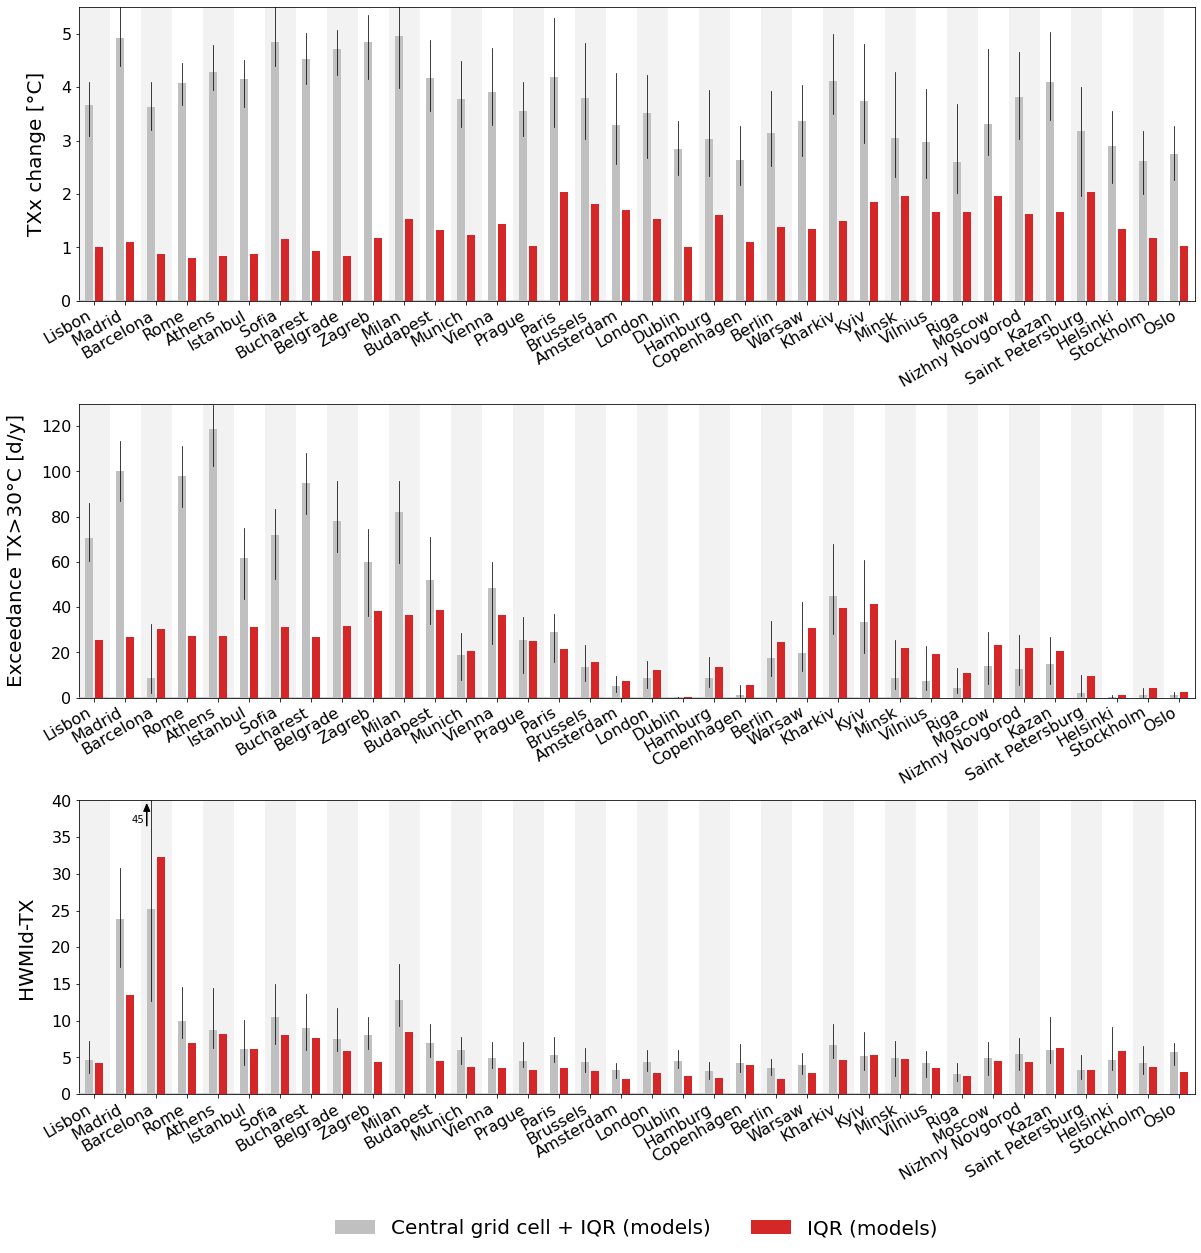

In [14]:
indicators = ['HSIchg', 'ThrExc', 'HWMID']
selections = ['point', 'difference']
N = len(selections)

#Define HSI
HSI = 'TX'

#Select which time method to use for HSI changes ('JJA_mean', 'Q90', 'Ymax')
t_method = 'Ymax'

#Select threshold level
THR_level = 'Level' + str(THR_levels[HSI])
    
    
#Create figure
fig, axes = plt.subplots(3, 1, figsize=(20, 20))
plt.subplots_adjust(hspace=0.35)
p_all = []


#Loop over indicators
for i1, indicator in enumerate(indicators):
    
    ax = axes[i1]
    
    
    if indicator=='HWMID':
        
        #Read data
        fname_pnt = dir_data_HWMId + 'EURO-CORDEX/HWMId-' + HSI + '_rcp85_EMT.nc'
        data_HWMId_pnt = xr.open_dataset(fname_pnt)

        #Select EMT and quantile
        data_pnt = data_HWMId_pnt.sel(EMT_change=EMT_change, quantile='Q50').HWMID

    elif indicator=='ThrExc':
        
        #Read data
        fname_pnt = dir_data_ThrExc + 'EURO-CORDEX/HSIs-ThresholdExceedance_rcp85_EMT.nc'
        data_ThrExc_pnt = xr.open_dataset(fname_pnt)

        #Select EMT, transformation and threshold level
        data_pnt = data_ThrExc_pnt.sel(EMT_change=EMT_change, transformation='no_trans', THR_level=THR_level)[HSI]
    
    elif indicator=='HSIchg':
    
        #Read data
        fname_pnt = dir_data_HSIchg + 'EURO-CORDEX/HSIs-changes_rcp85_EMT.nc'
        data_HSIchg_pnt = xr.open_dataset(fname_pnt)
        
        #Select EMT and averaging method
        data_pnt = data_HSIchg_pnt.sel(EMT_change=EMT_change, t_method=t_method)[HSI]

    #Loop over cities
    for i3, city in enumerate(cities):

        #Loop over transformations
        for i2, selection in enumerate(selections):

            data_plot = data_pnt.sel(city=city)


            Q50 = data_plot.median('model')
            Q25 = data_plot.quantile(0.25, 'model')
            Q75 = data_plot.quantile(0.75, 'model')

            x = (N+1)*i3 + i2

            
            if selection=='point':
                data_bar = Q50
                color = 'silver'
                hatch = ''
            elif selection=='difference':
                data_bar = Q75 - Q25
                color = 'tab:red'
                hatch = ''            
            
            #Plot median
            bp = ax.bar(x, data_bar, color=color, hatch=hatch, zorder=5)

            #Plot uncertainty
            if selection=='point':
                ax.plot([x, x],[Q25, Q75], color='k', linewidth=0.75, zorder=8)

            #Collect plot handles for legend
            if i3==0 and i1==0:
                p_all.append(bp)
                
            #Display Q75 values for Barcelona
            if city=='Barcelona' and indicator=='HWMID':
                if selection=='point':
                    ax.arrow(x - 0.4, 36.5, 0, 2, fc="k", ec="k", head_width=0.6, head_length=1)
                    ax.text(x - 0.6, 37, "{:.0f}".format(Q75.item()), ha='right')
                elif selection=='3x3':
                    ax.arrow(x + 0.5, 36.5, 0, 2, fc="k", ec="k", head_width=0.6, head_length=1)
                    ax.text(x + 0.7, 37, "{:.0f}".format(Q75.item()), ha='left')
                    
        #Set background color
        if np.mod(i3,2)==0:
            ax.axvspan((N+1)*i3 - 1, (N+1)*i3 + (N+1) - 1, facecolor='black', alpha=0.05, zorder=1)

    #Plot zero-line
    ax.plot([-2, N*len(city)*len(selection)], [0,0], color='silver', zorder=3)

    #Set ticks, limits and labels
    xticks = np.arange((N-1)/2, len(cities_out) * (N + 1), N + 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(cities_out, rotation=30, ha='right', fontsize=16)
    ax.set_xlim([-1, (N + 1) * len(cities) - 1])
    ax.set_ylim(lims[indicator])
    ax.set_ylabel(titles[indicator](HSI, THR_level) + units[indicator], fontsize=20, labelpad=15)
    ax.tick_params(axis="y", labelsize=16)

    #Legend
    ax.legend(p_all, [labels_leg[sel] for sel in selections], frameon=False, fontsize=20, ncol=N,
                       loc='lower center', bbox_to_anchor=(0.5, -0.55))

# #Save figure
# plt.savefig(dir_fig + 'FigS_Comparsion_3x3_one_gridpoint_EURO-CORDEX_' + EMT_change + '_v2.png', bbox_inches='tight', dpi=300)
